<a href="https://colab.research.google.com/github/averyrair/ChessBAKEN/blob/main/PositionEvaluation/EvaluatorBAKEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install chess
!pip install stockfish
!apt install stockfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=e2623df7f3dcfb4beeba6ea08a960670e3d3cb1618b1cc3d715199deab846e91
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 2s (13.8 MB/s)
Selecting previously unselected package stockfish.
(Reading database ... 126315 files and directories cur

In [ ]:
# @title Get board positions from inputted file

import chess.pgn
import csv

# Open PGN file
f = 'KingBase2019-A80-A99.pgn'
pgn = open(f, encoding='latin-1')

# Prepare CSV file
with open("game_positions_mini.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["pos", "turn", "result"])  # header

    game_count = 0
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break  # No more games

        result_str = game.headers.get("Result", "*")
        if result_str == "1-0":
            result = 1
        elif result_str == "0-1":
            result = -1
        elif result_str == "1/2-1/2":
            result = 0
        else:
            continue  # Skip games with unknown result

        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            pos = board.fen().split()[0]
            turn = 1 if board.turn == chess.WHITE else 0
            writer.writerow([pos, turn, result])

        game_count += 1
        if game_count % 100 == 0:
            print(f"Processed {game_count} games...")
        if game_count == 500:
            break

print("Done.")

In [5]:
# @title Encode the 768 positions and current player turn

import csv
import numpy as np
from sklearn.model_selection import train_test_split

# One-hot encode 64 squares × 12 possible piece types
def encode_board_only(fen: str) -> list:
    encoded = [0] * 768
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    rows = fen.split('/')
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece_index = piece_to_index[char]
                square_index = row_idx * 8 + col_idx
                flat_index = square_index * 12 + piece_index
                encoded[flat_index] = 1
                col_idx += 1
    return encoded

def load_encoded_data(csv_file):
    X, y = [], []
    with open(csv_file, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            fen = row["pos"]
            turn = int(row["turn"])
            result = int(row["result"])
            board_encoded = encode_board_only(fen)
            input_vector = board_encoded + [turn]
            X.append(input_vector)
            y.append(result)
    return np.array(X), np.array(y)

In [7]:
# @title Encode positions for CNN

import csv
import numpy as np
import torch

# 12x8x8 for piece positions
def encode_board_12x8x8(fen: str) -> np.ndarray:
    board = np.zeros((12, 8, 8), dtype=np.float32)
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    rows = fen.split('/')
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece_index = piece_to_index[char]
                board[piece_index, row_idx, col_idx] = 1
                col_idx += 1
    return board

# Final shape: (13, 8, 8)
def encode_input_13x8x8(fen: str, turn: int) -> np.ndarray:
    board_tensor = encode_board_12x8x8(fen)  # shape: (12, 8, 8)

    # Turn channel
    turn_channel = np.full((1, 8, 8), turn, dtype=np.float32)

    # Stack them together
    return np.concatenate([board_tensor, turn_channel], axis=0)

# 12 piece positions on an 8x8
# 1 player trun on an 8x8
def load_encoded_data_13x8x8(csv_file):
    X, y = [], []
    with open(csv_file, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            fen = row["pos"]
            turn = int(row["turn"])
            result = int(row["result"])

            encoded = encode_input_13x8x8(fen, turn)
            X.append(encoded)
            y.append(result)
    return np.array(X), np.array(y)

In [8]:
# Loaded data for fully connected NN
# X, y = load_encoded_data("game_positions_mini.csv")
# Loaded data for CNN 13 channels 8x8 board positions
X, y = load_encoded_data_13x8x8("game_positions_mini.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 67922
Test size: 16981


In [11]:
# @title CNN architecture

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Architecture reference from: https://www.diva-portal.org/smash/get/diva2:1366229/FULLTEXT01.pdf

# CNN with 13 channels

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()

        self.conv1 = nn.Conv2d(13, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.tanh(x)

        return x

In [12]:
# @title Training the CNN

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Initialize model, loss, and optimizer
model = ChessNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().view(-1, 1)

# Create dataset and dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 50
loss_vals = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    loss_vals.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/50, Loss: 0.5951
Epoch 2/50, Loss: 0.4463
Epoch 3/50, Loss: 0.3625
Epoch 4/50, Loss: 0.3180
Epoch 5/50, Loss: 0.2874
Epoch 6/50, Loss: 0.2689
Epoch 7/50, Loss: 0.2535
Epoch 8/50, Loss: 0.2409
Epoch 9/50, Loss: 0.2330
Epoch 10/50, Loss: 0.2252
Epoch 11/50, Loss: 0.2179
Epoch 12/50, Loss: 0.2130
Epoch 13/50, Loss: 0.2098
Epoch 14/50, Loss: 0.2039
Epoch 15/50, Loss: 0.2006
Epoch 16/50, Loss: 0.1962
Epoch 17/50, Loss: 0.1934
Epoch 18/50, Loss: 0.1901
Epoch 19/50, Loss: 0.1861
Epoch 20/50, Loss: 0.1864
Epoch 21/50, Loss: 0.1836
Epoch 22/50, Loss: 0.1800
Epoch 23/50, Loss: 0.1794
Epoch 24/50, Loss: 0.1769
Epoch 25/50, Loss: 0.1763
Epoch 26/50, Loss: 0.1745
Epoch 27/50, Loss: 0.1714
Epoch 28/50, Loss: 0.1700
Epoch 29/50, Loss: 0.1675
Epoch 30/50, Loss: 0.1669
Epoch 31/50, Loss: 0.1661
Epoch 32/50, Loss: 0.1646
Epoch 33/50, Loss: 0.1631
Epoch 34/50, Loss: 0.1632
Epoch 35/50, Loss: 0.1613
Epoch 36/50, Loss: 0.1593
Epoch 37/50, Loss: 0.1590
Epoch 38/50, Loss: 0.1591
Epoch 39/50, Loss: 0.

In [ ]:
# @title Basic NN architecture

import torch
import torch.nn as nn
import torch.optim as optim

# Maybe add batchnorm?
class ChessNet(nn.Module):
  def __init__(self):
    super(ChessNet, self).__init__()
    self.fc1 = nn.Linear(769, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.tanh(self.fc3(x))
    return x

# Create the model, loss, and optimizer
model = ChessNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert np arrays to tensors
X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)

loss_vals = []
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.7192428708076477
Epoch 100, Loss: 0.19723211228847504
Epoch 200, Loss: 0.13925382494926453
Epoch 300, Loss: 0.1272897720336914
Epoch 400, Loss: 0.12054167687892914
Epoch 500, Loss: 0.11674460768699646
Epoch 600, Loss: 0.11300092190504074
Epoch 700, Loss: 0.11242204904556274
Epoch 800, Loss: 0.10994042456150055
Epoch 900, Loss: 0.10900834202766418


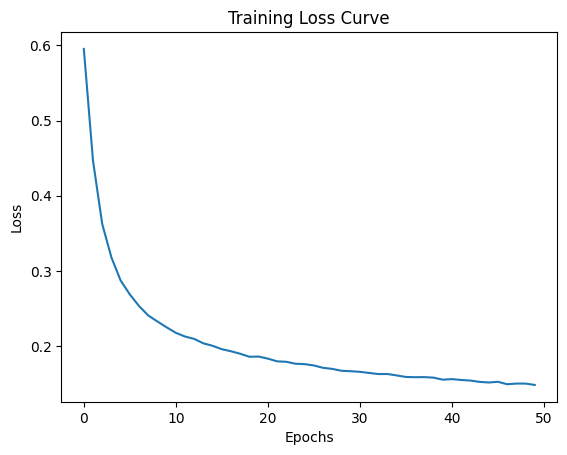

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_vals)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Convert test dataset to tensors
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)

# Set the model evaluation mode
model.eval()

# Disable gradients to pass through the NN
with torch.no_grad():
    output = model(X_test)

# Label the outputs in terms of their range
def label_output(value):
    if value <= -0.33:
        return -1
    elif value <= 0.33:
        return 0
    else:
        return 1

# Apply the custom labeling function to the model output
predictions = output.numpy().flatten()
predicted_labels = np.array([label_output(val) for val in predictions])

# Convert the true labels (y_test) to -1, 0, or 1
true_labels = y_test.numpy().flatten()
true_labels_labeled = np.array([label_output(val) for val in true_labels])

# Calculate accuracy
accuracy = accuracy_score(true_labels_labeled, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate loss on the test dataset
criterion = nn.MSELoss()
test_loss = criterion(output, y_test)
print(f"Test Loss (MSE): {test_loss.item():.4f}")

Test Accuracy: 81.89%
Test Loss (MSE): 0.2007


In [ ]:
# How accurate is the move to a high-level player

model.eval()

for i in range(20):
    pos = X_test[i]
    true = y_test[i]

    pos = pos.unsqueeze(0)

    with torch.no_grad():
        output = model(pos)
        prediction = output

    print(f"Position {i+1}:")
    print(f"True Value: {true}")
    print(f"Predicted Value: {prediction}\n")

In [ ]:
# @title NATHANAEL THIS IS FOR YOU

def encode_board_only(fen):
    encoded = [0] * 768
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    rows = fen.split('/')
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece_index = piece_to_index[char]
                square_index = row_idx * 8 + col_idx
                flat_index = square_index * 12 + piece_index
                encoded[flat_index] = 1
                col_idx += 1
    return encoded

# Extract the fen of the board and get the exact position
board_position = board.fen().split()[0]
# Endcode the position to the correct format: 768 items
encoding = encode_board_only(board_position)
# Get whose turn it is
turn = 1 if board.turn == chess.WHITE else 0
# Combine the encoding with the turn: 769 items
inp = encoding + [turn]
# Convert the combined encoding to a tensor
e = torch.tensor(np.array(inp), dtype=torch.float32)

# Model in eval mode
model.eval()

# Preprocess the input
pos = e.unsqueeze(0)

# Run the model without gardients
with torch.no_grad():
    # Model output and prediction
    output = model(pos)
    prediction = output
print(prediction)

In [ ]:
import chess
import chess.svg
import chess.pgn
import random
import matplotlib.pyplot as plt
from IPython.display import display, SVG

def display_chess_board(fen):
    board = chess.Board(fen)
    svg_data = chess.svg.board(board, size=250)
    display(SVG(svg_data))

def read_and_display_first_game(pgn_file):
    itr = 0
    with open(pgn_file) as f:
        game = chess.pgn.read_game(f)
        if game:
            board = game.board()
            for move in game.mainline_moves():
                board.push(move)
                itr+=1
                if itr == 80:
                    encoding = encode_board_only(board.fen().split()[0])
                    turn = 1 if board.turn == chess.WHITE else 0
                    inp = encoding + [turn]
                    e = torch.tensor(np.array(inp), dtype=torch.float32)

                    print(turn)

                    model.eval()

                    pos = e.unsqueeze(0)

                    with torch.no_grad():
                        output = model(pos)
                        prediction = output
                    print(prediction)

                    result_str = game.headers.get("Result", "*")
                    if result_str == "1-0":
                        print('White won')
                    elif result_str == "0-1":
                        print('Black won')
                    elif result_str == "1/2-1/2":
                        print('Tie')
                    else:
                        continue

                    display_chess_board(board.fen())
        else:
            print("No games found in the PGN file.")

pgn_file = "KingBase2019-A80-A99.pgn"
read_and_display_first_game(pgn_file)